In [11]:
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
from torch.autograd.functional import jacobian
import sys
import copy
import pathlib
from pathlib import Path
cwd = Path().resolve()
import os
from os import path
# __file__ should be defined in this case
PARENT_DIR = path.dirname(cwd)
sys.path.append(PARENT_DIR)
import pickle as pkl

## Extracting results

**NOTE**: Currently this is being hardcoded for obtaining results related to the Lorenz-63 attractor SSM with ReLU nonlinearity, for SemiDANSE+ and comparative methods

The results for model-driven filters are stored in `FIGDIR_MODELDRIVEN`
The data-driven methods with SemiDANSE+ and the supervised formulation of SemiDANSE+ with $\kappa=2\%$ are stored in:

- `FIGDIR_DANSE_RELATED_nsup0` for $\kappa=0\%$
- `FIGDIR_DANSE_RELATED_nsup20` for $\kappa=2\%$
- `FIGDIR_DANSE_RELATED_nsup1000` for $\kappa=100\%$

In [12]:
FIGDIR_MODELDRIVEN = "../figs_final_with_LorenzSSM_relu_models/LorenzSSMn3x3_relu/ModTest_diff_smnr_models_Ntrain_1000_Ttrain_200_Ntest_100_Ttest_2000_nparticles_100/"
FIGDIR_DANSE_RELATED_nsup0 = "../figs_final_with_relu_sup/LorenzSSMn3x3_relu/ModTest_diff_smnr_nsup_0_Ntrain_1000_Ttrain_200_Ntest_100_T_test_2000_refactored_nparticles_100/"
FIGDIR_DANSE_RELATED_nsup20 = "../figs_final_with_relu_sup/LorenzSSMn3x3_relu/ModTest_diff_smnr_nsup_20_Ntrain_1000_Ttrain_200_Ntest_100_T_test_2000_refactored_nparticles_100/"
FIGDIR_DANSE_RELATED_nsup1000 = "../figs_final_with_relu_sup/LorenzSSMn3x3_relu/ModTest_diff_smnr_nsup_1000_Ntrain_1000_Ttrain_200_Ntest_100_T_test_2000_refactored_nparticles_100/"

In [13]:
def load_results_data(file):
    with open(file, 'rb') as f:
        results = torch.load(f)
    return results

In [54]:
smnr_test_dB = 10.0
results_modeldriven_ = load_results_data(os.path.join(
    FIGDIR_MODELDRIVEN, "test_results_models_smnr_{}.pt".format(smnr_test_dB)
))
test_data_file = "../data/synthetic_data/test_trajectories_m_3_n_3_LorenzSSM_relu_data_T_2000_N_100_sigmae2_-10.0dB_smnr_{}dB.pkl".format(smnr_test_dB)
test_data = pkl.load(open(test_data_file, 'rb'))
X_true = test_data['X']
Y_true = test_data['Y']
Cw_true = test_data['Cw']
U_true = test_data['U']
ssm_model = test_data['model']

### Quick visualization of the effect of the measurement non-linearity $h(x) = \text{ReLU}(x)$


<Figure size 432x288 with 0 Axes>

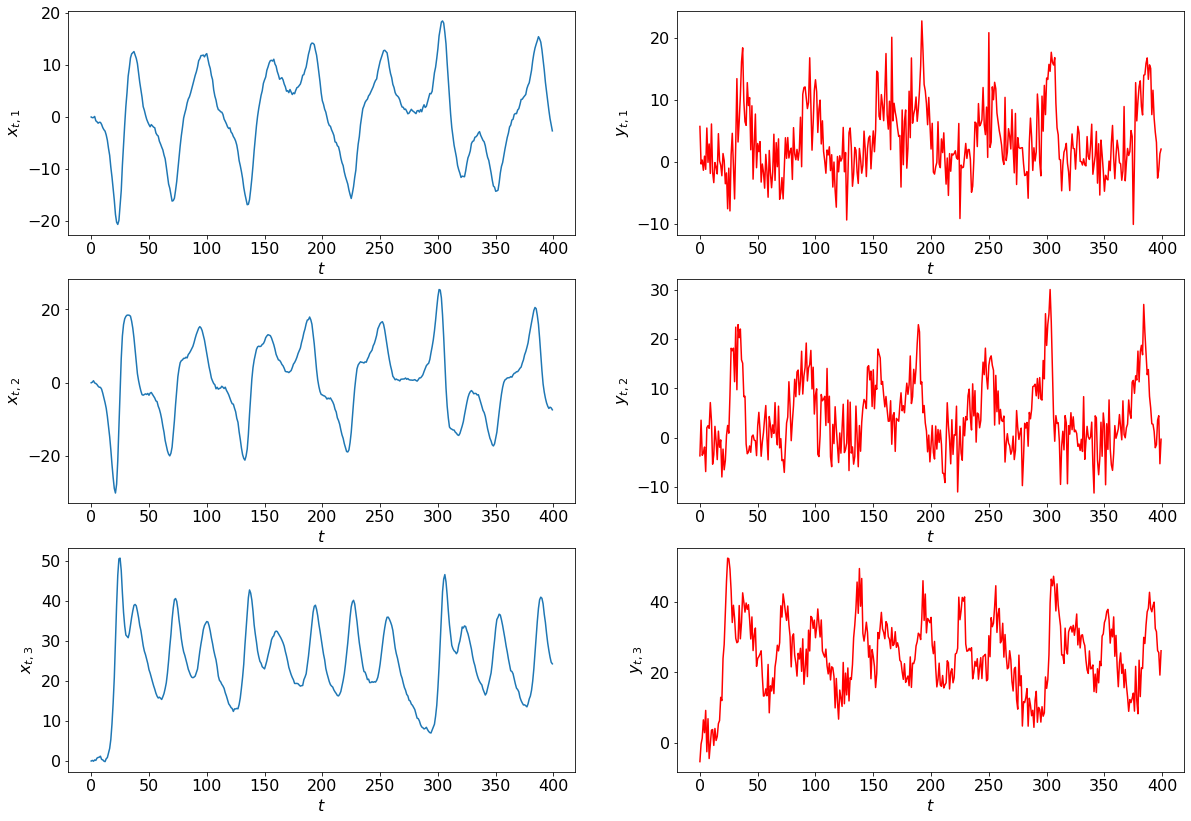

In [55]:
id_ = np.random.randint(0, X_true.shape[0])
T_end = X_true.shape[1] // 5
plt.figure()
plt.rcParams['font.size'] = 16
fig, axs = plt.subplots(3,2,figsize=(20,14))
axs[0][0].plot(X_true[id_, :T_end, 0]) 
axs[0][0].set_ylabel('$x_{t,1}$')
axs[0][0].set_xlabel('$t$')

axs[0][1].plot(Y_true[id_, :T_end, 0], 'r') 
axs[0][1].set_ylabel('$y_{t,1}$')
axs[0][1].set_xlabel('$t$')

axs[1][0].plot(X_true[id_, :T_end, 1]) 
axs[1][0].set_ylabel('$x_{t,2}$')
axs[1][0].set_xlabel('$t$')

axs[1][1].plot(Y_true[id_, :T_end, 1], 'r') 
axs[1][1].set_ylabel('$y_{t,2}$')
axs[1][1].set_xlabel('$t$')

axs[2][0].plot(X_true[id_, :T_end, 2]) 
axs[2][0].set_ylabel('$x_{t,3}$')
axs[2][0].set_xlabel('$t$')

axs[2][1].plot(Y_true[id_, :T_end, 2], 'r') 
axs[2][1].set_ylabel('$y_{t,3}$')
axs[2][1].set_xlabel('$t$')

#plt.legend()
plt.show()


### Metrics (NMSE, MSE) for different SMNRs 

In [57]:
import json
def load_metrics_json(file):
    with open(file, 'rb') as f:
        metrics = json.load(f)
    return metrics

In [75]:
METRICSJSON_MODELDRIVEN = "../figs_final_with_LorenzSSM_relu_models/LorenzSSM_relu_test_ModTest_diff_smnr_models_Ntrain_1000_Ttrain_200_Ntest_100_Ttest_2000_nparticles_100_T_2000_N_100_ModTest_allmodels.json"
METRICSJSON_DANSE_nsup0 = "../figs_final_with_relu_sup/LorenzSSM_relu_test_ModTest_diff_smnr_nsup_0_Ntrain_1000_Ttrain_200_Ntest_100_T_test_2000_refactored_nparticles_100_T_2000_N_100_ModTest.json"
METRICSJSON_DANSE_nsup20 = "../figs_final_with_relu_sup/LorenzSSM_relu_test_ModTest_diff_smnr_nsup_20_Ntrain_1000_Ttrain_200_Ntest_100_T_test_2000_refactored_nparticles_100_T_2000_N_100_ModTest.json"
METRICSJSON_DANSE_nsup1000 = "../figs_final_with_relu_sup/LorenzSSM_relu_test_ModTest_diff_smnr_nsup_1000_Ntrain_1000_Ttrain_200_Ntest_100_T_test_2000_refactored_nparticles_100_T_2000_N_100_ModTest.json"

In [76]:
# ((nmse, nmse_std, mse, mse_std, time), (ls,ukf,pf), smnrs)
metrics_modeldriven_multidimmat = np.array(load_metrics_json(METRICSJSON_MODELDRIVEN)['result_mat'])
# ((nmse, nmse_std, mse, mse_std, time), (ls,danse_sup_20,semidanse+), smnrs)
metrics_danse_nsup0_multidimmat = np.array(load_metrics_json(METRICSJSON_DANSE_nsup0)['result_mat']) 
# ((nmse, nmse_std, mse, mse_std, time), (ls,danse_sup_20,semidanse+), smnrs)
metrics_danse_nsup20_multidimmat = np.array(load_metrics_json(METRICSJSON_DANSE_nsup20)['result_mat']) 
# ((nmse, nmse_std, mse, mse_std, time), (ls,danse_sup_20,semidanse+), smnrs)
metrics_danse_nsup1000_multidimmat = np.array(load_metrics_json(METRICSJSON_DANSE_nsup1000)['result_mat']) 

### Creating plot NMSE vs. SMNR for PF, SemiDANSE+ ($\kappa=0\%$) 

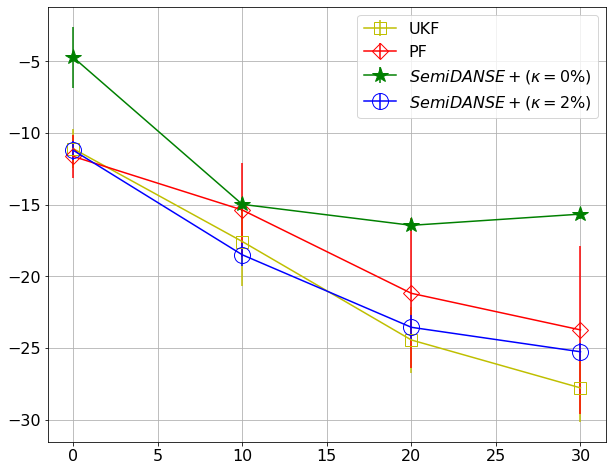

In [107]:
smnrs = np.array([0.0, 10.0, 20.0, 30.0])
plt.figure(figsize=(10,8))
plt.errorbar(
    smnrs, # smnrs
    metrics_modeldriven_multidimmat[0,-2,:], # nmse for pf,
    yerr=metrics_modeldriven_multidimmat[1,-2,:], # nmse_std for SemiDANSE (nusp=0)
    fmt='ys-',
    ms=12,
    fillstyle='none',
    label='UKF'
)
plt.errorbar(
    smnrs, # smnrs
    metrics_modeldriven_multidimmat[0,-1,:], # nmse for pf,
    yerr=metrics_modeldriven_multidimmat[1,-1,:], # nmse_std for SemiDANSE (nusp=0)
    fmt='rD-',
    ms=12,
    fillstyle='none',
    label='PF'
)
plt.errorbar(
    smnrs,
    metrics_danse_nsup0_multidimmat[0,-1,:], # nmse for SemiDANSE (nusp=0)
    yerr=metrics_danse_nsup0_multidimmat[1,-1,:], # nmse_std for SemiDANSE (nusp=0),
    fmt='g*-',
    ms=16,
    label='$SemiDANSE+ (\kappa=0\%)$'
)
plt.errorbar(
    smnrs,
    metrics_danse_nsup20_multidimmat[0,-1,:], # nmse for SemiDANSE (nusp=0)
    yerr=metrics_danse_nsup20_multidimmat[1,-1,:], # nmse_std for SemiDANSE (nusp=0),
    fmt='bo-',
    label='$SemiDANSE+ (\kappa=2\%)$',
    ms=16,
    fillstyle='none'
)
plt.grid(True)
plt.legend()
plt.show()

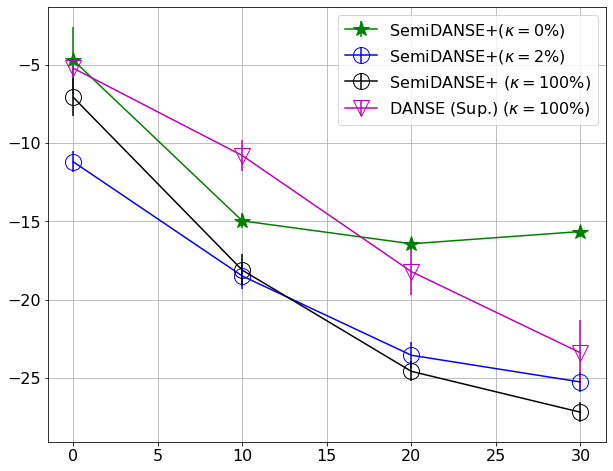

In [112]:
plt.figure(figsize=(10,8))
'''
plt.errorbar(
    smnrs, # smnrs
    metrics_modeldriven_multidimmat[0,-1,:], # nmse for pf,
    yerr=metrics_modeldriven_multidimmat[1,-1,:], # nmse_std for SemiDANSE (nusp=0)
    fmt='rD-',
    ms=12,
    fillstyle='none',
    label='PF'
)
'''
plt.errorbar(
    smnrs,
    metrics_danse_nsup0_multidimmat[0,-1,:], # nmse for SemiDANSE (nusp=0)
    yerr=metrics_danse_nsup0_multidimmat[1,-1,:], # nmse_std for SemiDANSE (nusp=0),
    fmt='g*-',
    ms=16,
    label='SemiDANSE+$ (\kappa=0\%)$'
)
plt.errorbar(
    smnrs,
    metrics_danse_nsup20_multidimmat[0,-1,:], # nmse for SemiDANSE (nusp=20)
    yerr=metrics_danse_nsup20_multidimmat[1,-1,:], # nmse_std for SemiDANSE (nusp=20),
    fmt='bo-',
    label='SemiDANSE+$ (\kappa=2\%)$',
    ms=16,
    fillstyle='none'
)
plt.errorbar(
    smnrs,
    metrics_danse_nsup1000_multidimmat[0,-1,:], # nmse for SemiDANSE (nusp=1000)
    yerr=metrics_danse_nsup1000_multidimmat[1,-1,:], # nmse_std for SemiDANSE (nusp=1000),
    fmt='ko-',
    label='SemiDANSE+ $ (\kappa=100\%)$',
    ms=16,
    fillstyle='none'
)
plt.errorbar(
    smnrs,
    metrics_danse_nsup20_multidimmat[0,-2,:], # nmse for DANSE Sup.
    yerr=metrics_danse_nsup20_multidimmat[1,-2,:], # nmse_std for DANSE Sup.
    fmt='mv-',
    label='DANSE (Sup.) $(\kappa=100\%)$',
    ms=16,
    fillstyle='none'
)
plt.grid(True)
plt.legend()
plt.show()

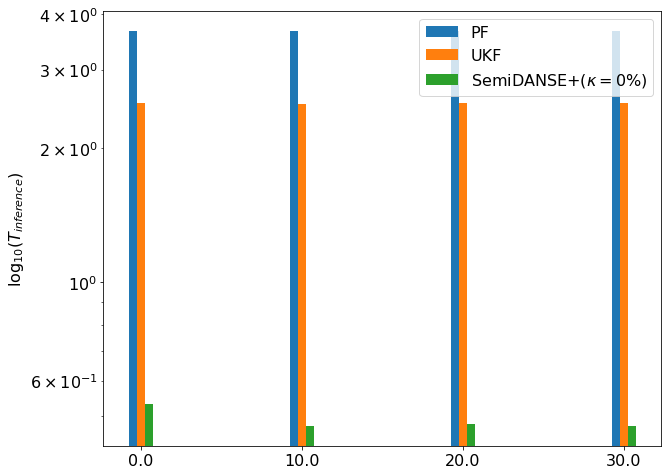

In [136]:
plt.figure(figsize=(10,8))
width = 0.5
plt.bar(
    smnrs,
    np.log10(metrics_modeldriven_multidimmat[-1,-1,:]), # pf
    label='PF',
    width = width,
    log=True
)
plt.bar(
    smnrs + width,
    np.log10(metrics_modeldriven_multidimmat[-1,-2,:]), # ukf
    label='UKF',
    width = width,
    log=True
)
plt.bar(
    smnrs + 2*width,
    np.log10(metrics_danse_nsup20_multidimmat[-1,-1,:]), # pf
    label='SemiDANSE+$(\kappa = 0\%)$',
    width = width,
    log=True
)
plt.legend()
plt.ylabel('$\log_{10}(T_{inference})$')
plt.xticks(width + smnrs, smnrs)
plt.show()